# An Introduction to PCA and Multi-Calss Classification with MNIST
_**Investigating Eigendigits from Principal Components Analysis on Handwritten Digits**_

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data inspection](#Data-inspection)
  4. [Data conversion](#Data-conversion)
3. [Training the PCA model](#Training-the-PCA-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
5. [Validate the model for use](#Validate-the-model-for-use)


## Introduction

Welcome to our example introducing Amazon SageMaker's PCA Algorithm! Today, we're analyzing the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset which consists of images of handwritten digits, from zero to nine.  We'll ignore the true labels for the time being and instead focus on what information we can obtain from the image pixels alone.

The method that we'll look at today is called Principal Components Analysis (PCA).  PCA is an unsupervised learning algorithm that attempts to reduce the dimensionality (number of features) within a dataset while still retaining as much information as possible. This is done by finding a new set of feature dimensions called principal components, which are composites of the original features that are uncorrelated with one another. They are also constrained so that the first component accounts for the largest possible variability in the data, the second component the second most variability, and so on.

PCA is most commonly used as a pre-processing step.  Statistically, many models assume data to be low-dimensional.  In those cases, the output of PCA will actually include much less of the noise and subsequent models can be more accurate.  Taking datasets with a huge number of features and reducing them down can be shown to not hurt the accuracy of the clustering while enjoying significantly improved performance.  In addition, using PCA in advance of a linear model can make overfitting due to multi-collinearity less likely.


To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables


Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
bucket = 'sagemaker-walebadr'
prefix = 'sagemaker/sagemaker-pca-mnist'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

### Data ingestion

Next, we read the dataset from an online URL into memory, for preprocessing prior to training. This processing could be done *in-situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present at the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. 

NOTE: pre-processing this specific dataset on the notebook instance and fitting it into memory should be ok but for bigger datasets, you will need to preprocess the data prior training.

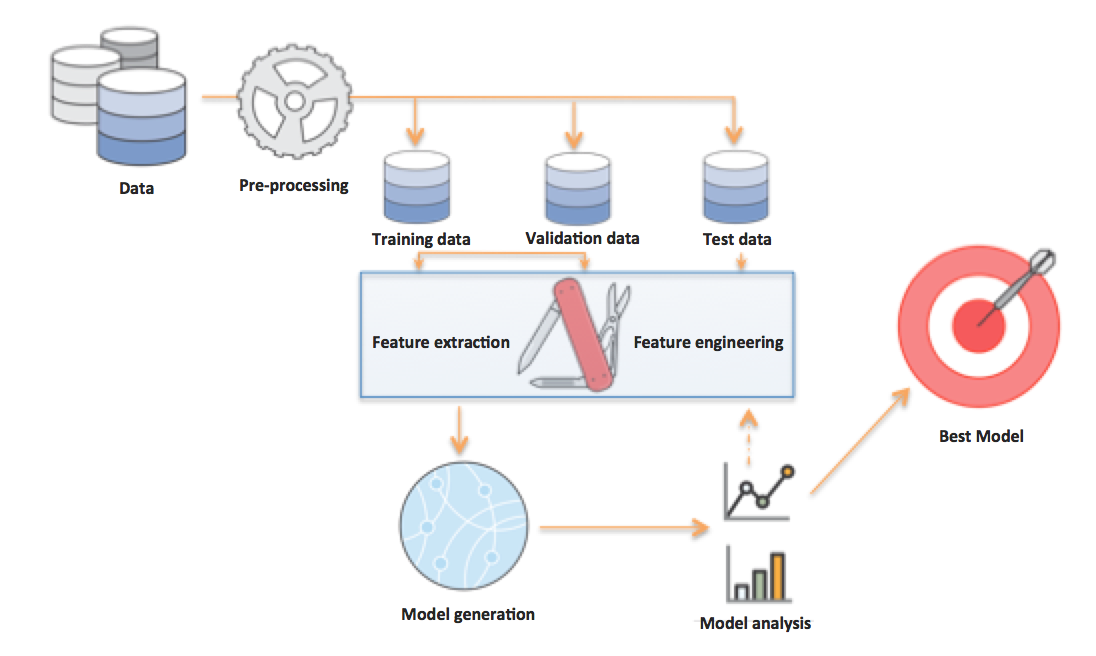




In [2]:
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

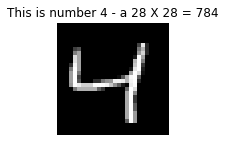

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][2], 'This is number {} - a 28 X 28 = 784'.format(train_set[1][2]))

### Data conversion

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the Amazon SageMaker implementation of PCA takes recordIO-wrapped protobuf , where the data we have today is a pickle-ized numpy array on disk.

The following code first uses the high-level Python library function, `write_numpy_to_dense_tensor`, to convert the training data into the protobuf format, which is efficient for model training.

In [4]:
import io
import numpy as np
import sagemaker.amazon.common as smac

vectors = np.array([t.tolist() for t in train_set[0]])
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors)
buf.seek(0)

0

## Upload training data
Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to S3, so that Amazon SageMaker training can use it.

In [5]:
import boto3
import os

key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-walebadr/sagemaker/sagemaker-pca-mnist/train/recordio-pb-data


## Training the PCA model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the PCA training algorithm, although we have tested it on multi-terabyte datasets.

Again, we'll use the Amazon SageMaker Python SDK to kick off training, and monitor status until it is completed.  In this example that takes between 7 and 11 minutes.  Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

First, let's specify our containers.  Since we want this notebook to run in all 4 of Amazon SageMaker's regions, we'll create a small lookup.  More details on algorithm containers can be found in [AWS documentation](https://docs-aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [6]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/pca:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/pca:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/pca:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/pca:latest',
              'ap-northeast-1': '351501993468.dkr.ecr.ap-northeast-1.amazonaws.com/pca:latest'}

Next we'll kick off the base estimator, making sure to pass in the necessary hyperparameters.  Notice:
- `feature_dim` is set to 784.  we are make predictions about individual images.
- `num_components` has been set to 10.  This could easily be increased for future experimentation.  In practical settings, setting the number of components typically uses a mixture of objective and subjective criteria.  Data Scientists tend to look for the fewest principal components that eat up the most variation in the data.
- `subtract_mean` standardizes the pixel intensity across all images.  The MNIST data has already been extensively cleaned, but including this shouldn't hurt.
- `algorithm_mode` is set to 'randomized'.  Because we have a very large number of dimensions, this makes the most sense.  The alternative 'stable' should be used in cases with a lower value for `feature_dim`.
- `mini_batch_size` has been set to 200.  For PCA, this parameter should not affect fit, but may have slight implications on timing.  Other algorithms may require tuning of this parameter in order to achieve the best results.

In [ ]:
import boto3
import sagemaker

sess = sagemaker.Session()

pca = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.c4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)
pca.set_hyperparameters(feature_dim=784,
                        num_components=50,
                        subtract_mean=True,
                        algorithm_mode='randomized',
                        mini_batch_size=200)

pca.fit({'train': s3_train_data})

## Training a PCA model in a private VPC

1- Create an S3 VPC endpoint for S3 private access.

2- Replace the below security groups with your own security groups that allows access to S3 (TCP port 443/80)

3- Replace the subnet-id with your own private subnet ID.

4- Execution Role should allow access to S3 resources. For more information on the required configurations, please refer to https://docs.aws.amazon.com/sagemaker/latest/dg/train-vpc.html


In [8]:
# Create a SageMaker Client
client = boto3.client('sagemaker')

#Defining the VPC Configurations:
SecurityGroups = ['<security group id>']
subnets = ['subnet-id']
jobName = 'PCA-trainingJob'
hyperparameters = {
    "feature_dim": "784",
    "num_components": "50",
    "subtract_mean": "True",
    "algorithm_mode":"randomized",
    "mini_batch_size": "200"
}


#Create a training Job
response = client.create_training_job(
    TrainingJobName=jobName,
    HyperParameters= hyperparameters,
    AlgorithmSpecification={
        'TrainingImage': containers[boto3.Session().region_name],
        'TrainingInputMode': 'File'
    },
    RoleArn='arn:aws:iam::625616379791:role/service-role/AmazonSageMaker-ExecutionRole-20171130T114980',
    InputDataConfig=[
        {
            'ChannelName': 'train',
            'DataSource': {
                'S3DataSource': {
                    'S3DataType': 'S3Prefix',
                    'S3Uri': s3_train_data,
                    'S3DataDistributionType': 'FullyReplicated'
                }
            },
        },
    ],
    OutputDataConfig={
        'S3OutputPath': output_location
    },
    ResourceConfig={
        'InstanceType': 'ml.c4.xlarge',
        'InstanceCount': 1,
        'VolumeSizeInGB': 10,
    },
    VpcConfig={
        'SecurityGroupIds': SecurityGroups,
        'Subnets': subnets
    },
    StoppingCondition={
        'MaxRuntimeInSeconds': 2400
    },
)

## Check the training Job Status

In [11]:
status = client.describe_training_job(TrainingJobName=jobName)['TrainingJobStatus']
print(status)
client.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=jobName)
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=distributed_job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

Completed
Training job ended with status: Completed


## Set up hosting for the model
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

_Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target._

In [ ]:
pca_predictor = pca.deploy(initial_instance_count=1,
                           instance_type='ml.t2.medium')

## Validate the model for use and make predictions
Finally, we can now validate the model for use.  We can pass HTTP POST requests to the endpoint to get back predictions.  To make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.

In [ ]:
from sagemaker.predictor import csv_serializer, json_deserializer

pca_predictor.content_type = 'text/csv'
pca_predictor.serializer = csv_serializer
pca_predictor.deserializer = json_deserializer

Now let's try getting a prediction for a single record using the `predict` function of the estimator.

In [ ]:
result = pca_predictor.predict(train_set[0][0])

## Data Conversion

In [ ]:
%%time

import struct
import io
import boto3
prefix = 'sagemaker/DEMO-xgboost-mnist'
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='libsvm')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='libsvm')
output_location = 's3://{}/{}/output'.format(bucket, prefix)


def write_to_s3(fobj, bucket, key):
    return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def get_pca_projected_data():
    eigendigits = []
    v_eigendigits = []
    for array in np.array_split(train_set[0], 800):
        result = pca_predictor.predict(array)
        eigendigits += [r['projection'] for r in result['projections']]
    train_eigendigits = np.array(eigendigits)
    
    for array in np.array_split(valid_set[0], 800):
        result = pca_predictor.predict(array)
        v_eigendigits += [r['projection'] for r in result['projections']]
    valid_eigendigits = np.array(v_eigendigits)
    return train_eigendigits, valid_eigendigits

## Train a simple multi-class Logistic Regression Classifier using Scikit Learn

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression
train_projected, valid_projected = get_pca_projected_data()
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(train_projected, train_set[1])

# Checking the training performance
While accuracy is not always the best metric for machine learning algorithms (precision, recall, F1 Score, ROC Curve, etc would be better), it is used here for simplicity.


In [ ]:
valid_acc = logisticRegr.score(valid_projected, valid_set[1]) * 100
print('The validation Accuracy is: %{}'.format(valid_acc))

# Prediction after dimension reduction

In [ ]:
from IPython.display import HTML
HTML(open("input.html").read())

In [ ]:
pca_result = pca_predictor.predict(np.array(data))
processed_result = np.array([t['projection'] for t in pca_result['projections']])
reg_result = logisticRegr.predict(processed_result.reshape(1,-1))

print('The number is: {}'.format(reg_result))

## Deploy to production Environment

In [11]:
!aws s3 cp s3://sagemaker-walebadr/sagemaker/DEMO-pca-mnist/output/pca-2018-06-15-15-06-42-733/output/model.tar.gz s3://prod-model-artifacts/prod-models/ --acl bucket-owner-full-control --metadata "One=Two"
!aws s3 cp ./deploy-template.zip s3://prod-model-artifacts/prod-models/ --acl bucket-owner-full-control --metadata "One=Two"
        

copy: s3://sagemaker-walebadr/sagemaker/DEMO-pca-mnist/output/pca-2018-06-15-15-06-42-733/output/model.tar.gz to s3://prod-model-artifacts/prod-models/model.tar.gz
upload: ./deploy-template.zip to s3://prod-model-artifacts/prod-models/deploy-template.zip


### (Optional) Delete the Endpoint

If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
#import sagemaker

#sagemaker.Session().delete_endpoint(pca_predictor.endpoint)